shape of dataset (512, 512, 100)
shape of maskset (512, 512, 100)


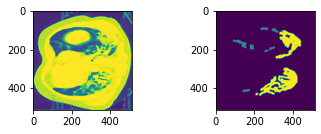

In [70]:
import matplotlib.pyplot as plt
import nibabel as nib
import random

# show original data and mask
data_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/imgs/tr_im.nii.gz'
mask_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/masks/tr_mask.nii.gz'

data = nib.load(data_path).get_fdata()
mask = nib.load(mask_path).get_fdata()

print("shape of dataset %s" % str(data.shape))
print("shape of maskset %s" % str(mask.shape))

rand = (random.randint(0, data.shape[2]))
img = data[:, :, rand]
msk = mask[:, :, rand]

plt.figure()
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.imshow(msk)
plt.show()


In [1]:
!python drive/My\ Drive/Pytorch-UNet-master/train.py \
# --load /content/drive/My\ Drive/Pytorch-UNet-master/checkpoints/CP_epoch10.pth

INFO: Using device cpu
400
2020-09-25 06:53:57.595352: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
INFO: Starting training:
        Epochs:          20
        Batch size:      1
        Learning rate:   0.001
        Checkpoints:     True
        Device:          cpu
    
0
  0% 0/6400 [06:08<?, ?it/s]
INFO: Saved interrupt


In [75]:
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np

def Dice(Yi,y_predi):
    Dices = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        if(2*TP+FP+FN == 0):
            dice = 0
        else:
            dice = 2*TP/float(2*TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, dice={:4.3f}".format(c,TP,FP,FN,dice))
        Dices.append(dice)
    mDice = np.mean(Dices)
    print("_________________")
    print("Mean Dice Score: {:4.3f}".format(mDice))
    return mDice

in_file_path = '/content/drive/My Drive/Pytorch-UNet-master/result_for_YL/1_100pre.nii.gz'
data = nib.load(in_file_path).get_fdata()
print(data.shape)
dicesum = 0
for i in range(data.shape[1]):
   plt.figure()   
   original_im = data[0, i, :, :]
   msk = data[1, i, :, :]
   im = data[2, i, :, :]

   mDice = Dice(msk, im)
   dicesum += mDice

   plt.subplot(1, 3, 1)
   plt.title("original")
   plt.imshow(original_im)
   plt.subplot(1, 3, 2)
   plt.title("gt")
   plt.imshow(msk)
   plt.subplot(1, 3, 3)
   plt.title("result")
   plt.imshow(im)
   plt.show()

print(dicesum / data.shape[1])


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!python drive/My\ Drive/Pytorch-UNet-master/predict.py \
--model /content/drive/My\ Drive/Pytorch-UNet-master/checkpoints/CP_epoch20.pth

In [46]:
import matplotlib.pyplot as plt
import os
import nibabel as nib
import numpy as np
# show the result

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 10)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def average_precision(img, msk):  
    h, w = img.shape
    same = np.sum(img == msk)

    return same / h / w

def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        if(2*TP+FP+FN == 0):
            IoU = 0
        else:
            IoU = 2*TP/float(2*TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean Dice Score: {:4.3f}".format(mIoU))
    return mIoU
# data_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/imgs/1_100.nii.gz'    
# result_path = '/content/drive/My Drive/Pytorch-UNet-master/result_test/1_100pre.nii.gz'
# mask_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/masks/1_100.nii.gz'

data_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/imgs/tr_im.nii.gz'    
result_path = '/content/drive/My Drive/Pytorch-UNet-master/result_test/1_100pre.nii.gz'
mask_path = '/content/drive/My Drive/Pytorch-UNet-master/1st_patient_data/masks/tr_mask.nii.gz'

data = nib.load(data_path).get_fdata()
mask = nib.load(mask_path).get_fdata()
result = nib.load(result_path).get_fdata()
print("the largest class number is : ")
print(np.max(mask))

print(mask.shape)

IoUsum = 0
for i in range(data.shape[2]):
   plt.figure()   
   original_im = data[:, :, i]
   msk = mask[:, :, i]
   im = result[:, :, i]
   im = np.pad(im, 62, pad_with, padder=0)    
   a_p = average_precision(im, msk)
   plt.suptitle('avg_prec=%.2f' % a_p)
   mIoU = IoU(msk, im)
   IoUsum += mIoU
   plt.subplot(1, 3, 1)
   plt.title("original")
   plt.imshow(original_im)
   plt.subplot(1, 3, 2)
   plt.title("gt")
   plt.imshow(msk)
   plt.subplot(1, 3, 3)
   plt.title("result")
   print(np.max(im))
   plt.imshow(im)
   plt.show()
print(IoUsum / data.shape[2])


Output hidden; open in https://colab.research.google.com to view.